## Intro to Domino Project

See the getting started [docs](https://docs.dominodatalab.com/en/4.1/get_started/index.html) to set up this project. This notebook outlines step 5, using Jupyter to load, explore, and transform some data. After the data has been prepared, we will train a model.

See [this document](https://www.bmreports.com/bmrs/?q=generation/fueltype/current) for information on the data and column headers.

##### quick validation that requirements for model deployment are met

In [1]:
! pip list | grep 'papermill\|pystan\|plotly\|dash\|fbprophet\|requests'

dash                               0.42.0   
dash-core-components               0.47.0   
dash-html-components               0.16.0   
dash-renderer                      0.23.0   
dash-table                         3.6.0    
dash-table-experiments             0.6.0    
plotly                             3.8.1    
requests                           2.21.0   
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install papermill pystan plotly dash fbprophet requests

     |████████████████████████████████| 67.3MB 98.7MB/s 
     |████████████████████████████████| 61kB 35.3MB/s 
     |████████████████████████████████| 102kB 44.1MB/s 
     |████████████████████████████████| 71kB 39.0MB/s 
     |████████████████████████████████| 71kB 37.8MB/s 
     |████████████████████████████████| 51kB 31.8MB/s 
     |████████████████████████████████| 122kB 72.7MB/s 
     |████████████████████████████████| 747kB 52.8MB/s 
     |████████████████████████████████| 1.2MB 71.7MB/s 
     |████████████████████████████████| 737kB 49.8MB/s 
  ERROR: Complete output from command /usr/local/anaconda/bin/python -u -c 'import setuptools, tokenize;__file__='"'"'/tmp/pip-install-_1y2ys8y/fbprophet/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-w7vgm81t --python-tag cp36:
  ERROR: running bdist_wheel
  running build
  running b

In [3]:
! pip list | grep 'papermill\|pystan\|plotly\|dash\|fbprophet\|requests'

dash                               0.42.0   
dash-core-components               0.47.0   
dash-html-components               0.16.0   
dash-renderer                      0.23.0   
dash-table                         3.6.0    
dash-table-experiments             0.6.0    
fbprophet                          0.6      
papermill                          2.1.2    
plotly                             3.8.1    
pystan                             2.19.1.1 
requests                           2.21.0   
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
#import the packages we need
%matplotlib inline
import pandas as pd
import datetime

import pystan
from fbprophet import Prophet

In [5]:
import os
import numpy as np

In [ ]:
#read in our data
df = pd.read_csv('/domino/datasets/BMRS/data.csv', skiprows=1, skipfooter=1, header=None, engine='python')

In [26]:
#rename the columns
df.columns = ['HDF', 'date', 'half_hour_increment',
              'CCGT', 'OIL', 'COAL', 'NUCLEAR',
              'WIND', 'PS', 'NPSHYD', 'OCGT',
              'OTHER', 'INTFR', 'INTIRL', 'INTNED',
               'INTEW', 'BIOMASS', 'INTEM']

#look at our data frame
df.head()

,HDF,date,half_hour_increment,CCGT,OIL,COAL,NUCLEAR,WIND,PS,NPSHYD,OCGT,OTHER,INTFR,INTIRL,INTNED,INTEW,BIOMASS,INTEM
0,FUELHH,20200501,1,5697,0,0,5791,5722,10,182,0,151,1370,106,692,0,1448,688
1,FUELHH,20200501,2,5325,0,0,5790,5616,0,181,0,152,1368,0,692,0,1461,688
2,FUELHH,20200501,3,5371,0,0,5787,5455,56,181,0,169,1368,0,690,0,1444,688
3,FUELHH,20200501,4,5391,0,0,5785,5656,0,181,0,146,1368,0,692,0,1446,688
4,FUELHH,20200501,5,5239,0,0,5786,5628,0,165,0,154,1368,0,690,0,1446,688


In [27]:
#Create a new column datetime that represents the starting datetime of the measured increment
df['datetime'] = pd.to_datetime(df['date'], format="%Y%m%d")
df['datetime'].describe()

count                    3391
unique                     71
top       2020-06-14 00:00:00
freq                       48
first     2020-05-01 00:00:00
last      2020-07-10 00:00:00
Name: datetime, dtype: object

In [28]:
df['datetime'] = df.apply(lambda x:x['datetime']+ datetime.timedelta(minutes=30*(int(x['half_hour_increment'])-1)), 
                          axis = 1)

In [29]:
df['datetime'].describe()

count                    3391
unique                   3391
top       2020-06-09 12:30:00
freq                        1
first     2020-05-01 00:00:00
last      2020-07-10 15:00:00
Name: datetime, dtype: object

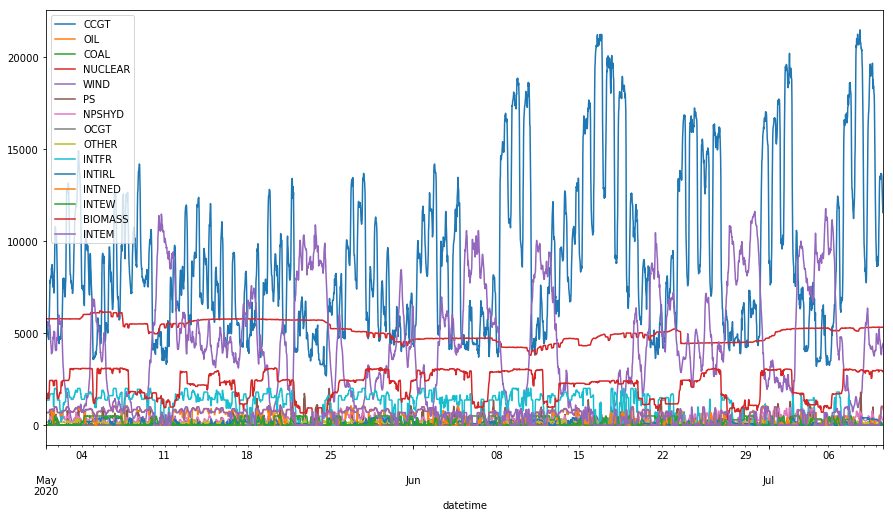

In [30]:
#Visualize the data to see how each fuel type is used during the day by plotting the data
df.drop(['HDF', 'date', 'half_hour_increment'], axis = 1).set_index('datetime').plot(figsize=(15,8));

### Train our model
The CCGT column representing “combined-cycle gas turbines” seems to be the most interesting. It generates a lot of energy and is very volatile.

We will concentrate on this column and try to predict the power generation from this fuel source.

In [31]:
df['y'] = df.drop(['date','HDF','half_hour_increment'],axis=1).sum(axis=1)

### New plot with total power generation

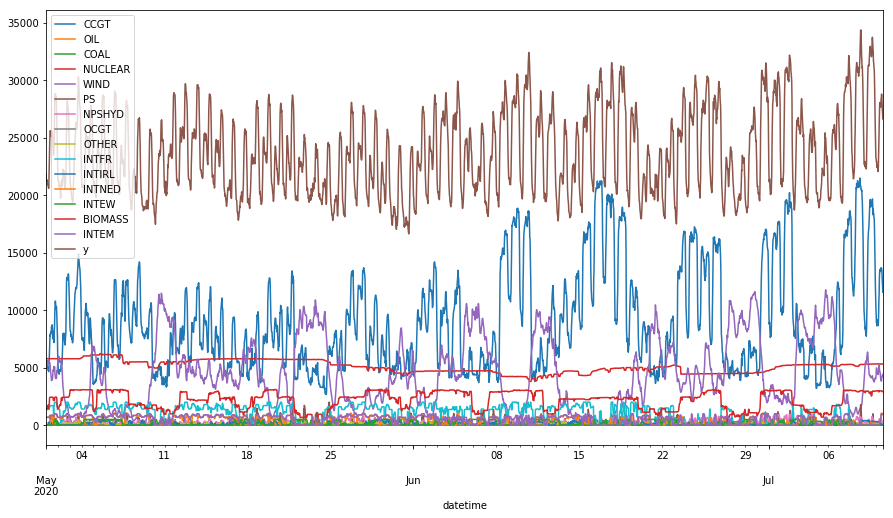

In [32]:
df.drop(['HDF', 'date', 'half_hour_increment'], axis = 1).set_index('datetime').plot(figsize=(15,8));

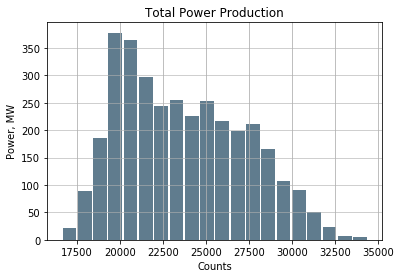

In [38]:
import matplotlib.pyplot as plt

df['y'].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')

plt.title('Total Power Production')
plt.xlabel('Counts')
plt.ylabel('Power, MW')
plt.grid(axis='y', alpha=0.75)

In [39]:
#Prep our data - for Facebook Prophet, the time series data needs to be in a DataFrame with 2 columns named ds and y
df_for_prophet = df[['datetime', 'y']].rename(columns = {'datetime':'ds'})

In [40]:
#Split the dataset into train and test sets
X = df_for_prophet.copy()
y = df_for_prophet['y']

proportion_in_training = 0.8
split_index = int(proportion_in_training*len(y))

In [41]:
X_train, y_train = X.iloc[:split_index], y.iloc[:split_index]
X_test, y_test = X.iloc[split_index:], y.iloc[split_index:]

In [42]:
#mport Facebook Prophet and fit a modek

m = Prophet(yearly_seasonality=False)
m.fit(X_train);

/usr/local/anaconda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [44]:
#Make a DataFrame to hold the predictions and predict future values of total power generation

future = m.make_future_dataframe(periods=int(len(y_test)), freq='30min')
forecast = m.predict(future)

#inspect the dataframe
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3386,2020-07-10 13:00:00,23239.366454,19927.860181,26861.286871
3387,2020-07-10 13:30:00,23051.768270,19923.710403,26493.662493
3388,2020-07-10 14:00:00,22949.755208,19424.420003,26130.647472
3389,2020-07-10 14:30:00,22963.581857,19801.060456,26333.142640
3390,2020-07-10 15:00:00,23117.808495,19907.812175,26577.418074


### to do - set up cutoff var to enable cross validation and observation of performance metrics

<Figure size 432x288 with 0 Axes>

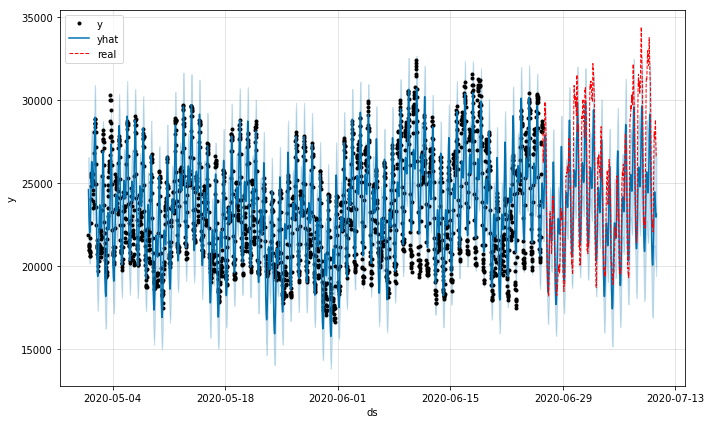

In [45]:
#Plot the fitted line with the training and test data
import matplotlib.pyplot as plt

plt.gcf();
fig = m.plot(forecast);
plt.plot(X_test['ds'].dt.to_pydatetime(), X_test['y'], 'r', linewidth = 1, linestyle = '--', label = 'real');
plt.legend();

### Export trained model
Trained models are meant to be used. There is no reason to re-train the model each time you use the model. Export or serialize the model to a file to load and reuse the model later. In Python, the pickle module implements protocols for serializing and de-serializing objects.

In [46]:
import pickle
m.stan_backend.logger = None    #uncomment if using Python 3.6 and fbprophet==0.6
with open("model.pkl", "wb") as f:
      pickle.dump(m, f)

### Dev: Export train, test+predictions, and ground truth labels for DMM example
Trained models are meant to be used. There is no reason to re-train the model each time you use the model. Export or serialize the model to a file to load and reuse the model later. In Python, the pickle module implements protocols for serializing and de-serializing objects.

In [146]:
def split_data_export(df,n,prefix):
    arrays = np.array_split(df,n)
    df_dict = {}
    file_names = list()
    
    for i in range(n):
        df_dict["partition{0}".format(i+1)] = arrays[i]
   
    for key, value in df_dict.items():
        if n ==1:
            name = os.environ['DOMINO_WORKING_DIR']+'/results/{0}_total.csv'.format(prefix)
        else:
            name = os.environ['DOMINO_WORKING_DIR']+'/results/{0}_total_{1}.csv'.format(prefix,key)
            
        file_names.append(name)   
        value.to_csv(name)

    return file_names

In [171]:
#train
train = df.copy().iloc[:split_index].drop(columns=['date','half_hour_increment'])
train.rename(columns = {'datetime':'ds'},inplace=True)
train.set_index('ds',inplace=True)
train.head()

,HDF,CCGT,OIL,COAL,NUCLEAR,WIND,PS,NPSHYD,OCGT,OTHER,INTFR,INTIRL,INTNED,INTEW,BIOMASS,INTEM,y
ds,,,,,,,,,,,,,,,,,
2020-05-01 00:00:00,FUELHH,5697,0,0,5791,5722,10,182,0,151,1370,106,692,0,1448,688,21857
2020-05-01 00:30:00,FUELHH,5325,0,0,5790,5616,0,181,0,152,1368,0,692,0,1461,688,21273
2020-05-01 01:00:00,FUELHH,5371,0,0,5787,5455,56,181,0,169,1368,0,690,0,1444,688,21209
2020-05-01 01:30:00,FUELHH,5391,0,0,5785,5656,0,181,0,146,1368,0,692,0,1446,688,21353
2020-05-01 02:00:00,FUELHH,5239,0,0,5786,5628,0,165,0,154,1368,0,690,0,1446,688,21164


In [172]:
split_data_export(train,1,'training')

['/mnt/results/training_total.csv']

In [149]:
#preds
#add underlying features back into prediction dataset
pred_data = df.copy().iloc[split_index:].drop(columns=['date','half_hour_increment','y']).rename(columns = {'datetime':'ds'}).set_index('ds')
pred_data.head()

,HDF,CCGT,OIL,COAL,NUCLEAR,WIND,PS,NPSHYD,OCGT,OTHER,INTFR,INTIRL,INTNED,INTEW,BIOMASS,INTEM
ds,,,,,,,,,,,,,,,,
2020-06-26 12:00:00,FUELHH,15211,0,0,4482,3252,0,257,0,111,0,0,802,0,3073,852
2020-06-26 12:30:00,FUELHH,15091,0,0,4485,3298,0,225,1,116,0,0,786,0,3062,852
2020-06-26 13:00:00,FUELHH,15557,0,0,4484,3054,0,219,1,124,0,0,0,0,3072,0
2020-06-26 13:30:00,FUELHH,15628,0,0,4480,2757,16,182,0,115,0,0,0,0,3048,0
2020-06-26 14:00:00,FUELHH,15710,0,0,4489,3194,42,181,0,115,0,0,0,0,3007,0


In [150]:
pred_data.shape

(679, 16)

In [151]:
preds = forecast.iloc[split_index:].set_index('ds')
preds.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,
2020-06-26 12:00:00,23928.893158,22460.261053,26178.514762,23928.893158,23928.893158,346.148402,346.148402,346.148402,362.787046,362.787046,362.787046,-16.638644,-16.638644,-16.638644,0.0,0.0,0.0,24275.041560
2020-06-26 12:30:00,23928.104776,22061.162875,25870.106682,23928.104776,23928.104776,82.486076,82.486076,82.486076,143.775731,143.775731,143.775731,-61.289655,-61.289655,-61.289655,0.0,0.0,0.0,24010.590852
2020-06-26 13:00:00,23927.316394,22003.173574,25617.775248,23927.316394,23927.316394,-158.157162,-158.157162,-158.157162,-51.704706,-51.704706,-51.704706,-106.452456,-106.452456,-106.452456,0.0,0.0,0.0,23769.159232
2020-06-26 13:30:00,23926.528012,21651.487191,25430.008186,23926.528012,23926.528012,-344.966964,-344.966964,-344.966964,-192.871279,-192.871279,-192.871279,-152.095685,-152.095685,-152.095685,0.0,0.0,0.0,23581.561048
2020-06-26 14:00:00,23925.739630,21490.786499,25202.630292,23925.739630,23925.739630,-446.191644,-446.191644,-446.191644,-248.004974,-248.004974,-248.004974,-198.186669,-198.186669,-198.186669,0.0,0.0,0.0,23479.547986


In [152]:
preds.shape

(679, 18)

In [153]:
preds = pd.merge(pred_data, preds, how='inner', on='ds')
preds = preds.rename(columns = {'yhat':'y'})
preds.shape

(679, 34)

In [154]:
preds.columns

Index(['HDF', 'CCGT', 'OIL', 'COAL', 'NUCLEAR', 'WIND', 'PS', 'NPSHYD', 'OCGT',
       'OTHER', 'INTFR', 'INTIRL', 'INTNED', 'INTEW', 'BIOMASS', 'INTEM',
       'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'y'],
      dtype='object')

In [155]:
split_data_export(preds,4,'inputs_and_preds')

['/mnt/results/inputs_and_preds_total_partition1.csv',
 '/mnt/results/inputs_and_preds_total_partition2.csv',
 '/mnt/results/inputs_and_preds_total_partition3.csv',
 '/mnt/results/inputs_and_preds_total_partition4.csv']

In [158]:
#ground truth
gt = pd.concat([y_test, X_test[['ds']]], axis=1, sort=False).rename(columns = {'y':'y_gt'}).reset_index(drop=True).set_index('ds')
gt.shape

(679, 1)

In [159]:
gt.head()

,y_gt
ds,
2020-06-26 12:00:00,28040
2020-06-26 12:30:00,27916
2020-06-26 13:00:00,26511
2020-06-26 13:30:00,26226
2020-06-26 14:00:00,26738


In [160]:
split_data_export(gt,4,'ground_truth')

['/mnt/results/ground_truth_total_partition1.csv',
 '/mnt/results/ground_truth_total_partition2.csv',
 '/mnt/results/ground_truth_total_partition3.csv',
 '/mnt/results/ground_truth_total_partition4.csv']